!pip install wordcloud
!pip install nltk

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()
comments = spark.read.text("comments.txt")


+--------+-----+
|        |count|
+--------+-----+
|?       |9    |
|종이    |8    |
|할      |8    |
|잘      |7    |
|그렇게  |7    |
|아닌    |7    |
|환경만  |6    |
|빨대는  |6    |
|말      |6    |
|환경파괴|6    |
|온갖    |6    |
|있는    |6    |
|이재명  |5    |
|법카로  |5    |
|단체는  |5    |
|한      |5    |
|한마디  |5    |
|니      |5    |
|선택적  |4    |
|내가    |4    |
+--------+-----+
only showing top 20 rows



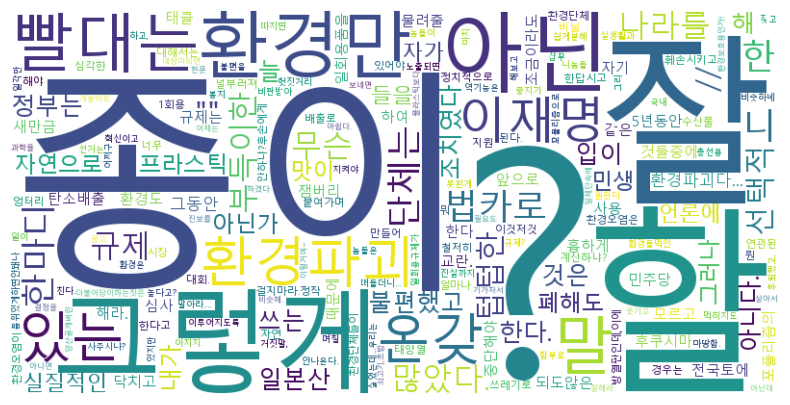

In [40]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col
import matplotlib.pyplot as plt
from matplotlib import font_manager
from wordcloud import WordCloud

# Spark 세션 생성
spark = SparkSession.builder.appName("WordCountExample").getOrCreate()

# CSV 파일을 읽어서 DataFrame 생성 (UTF-8로 인코딩된 파일이라 가정)
df = spark.read.csv("assembled_data.csv", header=True, inferSchema=True, encoding="EUC-KR")


# 'tag' 열에 따른 행 필터링
youtube_df = df.filter(df['tag'] == 'youtube')
instagram_df = df.filter(df['tag'] == 'instagram')
news_df = df.filter(df['tag'] == 'news')

# 'text' 열의 각 행에서 단어 분리 후 explode
words_df = news_df.select(explode(split(df['comment'], ' ')).alias(' '))

# 특정 단어 제외
exclude_words = [' ', '그', '그냥', '다', '더', '왜', '수', '진짜', '하면', '좀', 'ㅋ', 'ㅋㅋ', 'ㅋㅋㅋ', '하는', '안', '근데', '플라스틱', '일회용품', '빨대', '종이컵', '종이빨대', '일회용', '재활용', '컵', '환경']  # 제외하고 싶은 단어들
words_df = words_df.filter(~col(' ').isin(exclude_words))

# 각 단어별 count 계산
word_count = words_df.groupBy(' ').count()

# count 열을 기준으로 내림차순 정렬
word_count = word_count.orderBy("count", ascending=False)

# 결과 출력
word_count.show(truncate=False)

# 워드 클라우드 생성
font_path = "MALGUN.TTF"  # 원하는 한글 폰트 파일의 경로
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(dict(word_count.collect()))

# 워드 클라우드 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Spark 세션 종료
spark.stop()

# Spark 세션 종료
spark.stop()

+---------+--------------+-------------+
|tag      |total_comments|keyword_count|
+---------+--------------+-------------+
|instagram|977           |11           |
|news     |96            |11           |
|youtube  |6115          |133          |
+---------+--------------+-------------+

+---------+--------------+-------------+------------------+
|tag      |total_comments|keyword_count|keyword_percentage|
+---------+--------------+-------------+------------------+
|instagram|977           |11           |1.1258955987717503|
|news     |96            |11           |11.458333333333332|
|youtube  |6115          |133          |2.1749795584627964|
+---------+--------------+-------------+------------------+



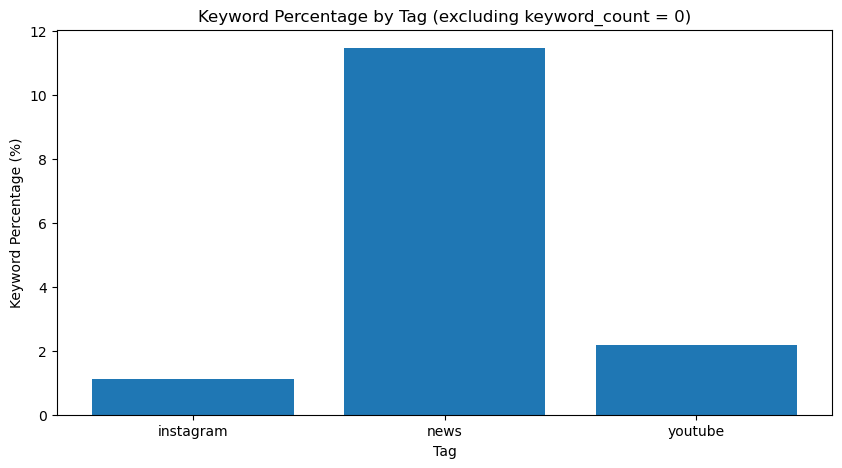

In [55]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Spark 세션 생성
spark = SparkSession.builder.appName("KeywordCount").getOrCreate()

# CSV 파일을 읽어서 DataFrame 생성 (EUC-KR로 인코딩된 파일이라 가정)
df = spark.read.csv("assembled_data.csv", header=True, inferSchema=True, encoding="EUC-KR")

# 특정 키워드 포함 여부를 나타내는 새로운 열 생성
df_with_keywords = df.withColumn("contains_keyword", when(col("comment").like("%이재명%") | col("comment").like("%문재인%") | col("comment").like("%윤석열%"), 1).otherwise(0))

# 태그별로 키워드가 포함된 댓글 수 계산
keyword_counts_by_tag = df_with_keywords.groupBy("tag").agg({"contains_keyword": "sum", "comment": "count"}).withColumnRenamed("sum(contains_keyword)", "keyword_count").withColumnRenamed("count(comment)", "total_comments")

# keyword_count가 0인 행 제거
keyword_counts_by_tag = keyword_counts_by_tag.filter(col("keyword_count") != 0)

# 결과 출력
keyword_counts_by_tag.show(truncate=False)

# 백분율 계산
keyword_counts_by_tag_percentage = keyword_counts_by_tag.withColumn("keyword_percentage", (col("keyword_count") / col("total_comments")) * 100)

# 결과 출력
keyword_counts_by_tag_percentage.show(truncate=False)

# Pandas DataFrame으로 변환
keyword_counts_pandas = keyword_counts_by_tag_percentage.toPandas()

# 바 차트로 시각화
plt.figure(figsize=(10, 5))
plt.bar(keyword_counts_pandas["tag"], keyword_counts_pandas["keyword_percentage"])
plt.xlabel("Tag")
plt.ylabel("Keyword Percentage (%)")
plt.title("Keyword Percentage by Tag (excluding keyword_count = 0)")
plt.show()

In [73]:
!pip install konlpy
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.2/464.2 kB 6.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 2.6 MB/s eta 0:00:0000:0100:01


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from konlpy.tag import Komoran

try:
    with open("comment.txt", "r", encoding="UTF-8") as file:
        comments = file.readlines()
except UnicodeDecodeError:
    print("UnicodeDecodeError: 파일을 읽는 중에 인코딩 에러가 발생했습니다.")


# KoNLPy의 Komoran 형태소 분석기 생성
komoran = Komoran()

# 불용어 제거
stop_words = set(["은", "는", "이", "가", "을", "를", "의", "에", "와", "과", "네", "들", "으로", "하다"])

# NetworkX 그래프 생성
G = nx.Graph()

# 댓글을 문장 단위로 토큰화하고 그래프에 추가
for comment in comments:
    sentences = comment.split('.')
    for sentence in sentences:
        # KoNLPy의 Komoran을 사용한 형태소 분석
        tokens = komoran.morphs(sentence)
        tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
        for i in range(len(tokens) - 1):
            word1 = tokens[i]
            word2 = tokens[i + 1]
            if not G.has_edge(word1, word2):
                G.add_edge(word1, word2, weight=1)
            else:
                G[word1][word2]["weight"] += 1

# 그래프 시각화
pos = nx.spring_layout(G, seed=42)  # 레이아웃 설정
nx.draw(G, pos, with_labels=True, font_weight="bold", node_size=700, node_color="skyblue", font_size=10, edge_color="gray", font_color="black")

# 간선의 두께를 단어 빈도에 비례하도록 설정
edge_widths = [d["weight"] for (u, v, d) in G.edges(data=True)]
edge_widths = [2 * (x / max(edge_widths)) for x in edge_widths]
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="gray")

plt.show()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xed in position 0: invalid continuation byte